# Unemployment Analysis in India (2019–2020)

**Author:** Aaditya Rathore  
**Project:** CodeAlpha — Task: Unemployment Analysis with Python

**Short summary:**  
This notebook analyzes monthly unemployment rate data across Indian regions, focusing on trends, seasonality, and the impact of COVID-19 (pre vs post March 1, 2020). The workflow includes data cleaning, EDA, time-series smoothing, statistical testing for COVID impact, and region-level comparisons. Visualizations are saved to `outputs/figures/` for submission.


In [23]:
# Imports and plotting settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import os

# Display options
pd.set_option('display.max_columns', 200)
plt.style.use('default')  # keep default style for reproducibility

# Create outputs folder if missing
Path('../outputs/figures').mkdir(parents=True, exist_ok=True)


In [24]:
# Imports and plotting settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import os

# Display options
pd.set_option('display.max_columns', 200)
plt.style.use('default')  # keep default style for reproducibility

# Create outputs folder if missing
Path('../outputs/figures').mkdir(parents=True, exist_ok=True)


In [25]:
# Load the chosen dataset (single source used for analysis)
DATA_PATH = "../data/Unemployment_Rate_upto_11_2020.csv"  # change path only if needed

df = pd.read_csv(DATA_PATH)

# Quick check
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
df.columns = df.columns.str.strip()
df.head(5)


Loaded: ../data/Unemployment_Rate_upto_11_2020.csv
Shape: (267, 9)


,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Region.1,longitude,latitude
0,Andhra Pradesh,31-01-2020,M,5.48,16635535,41.02,South,15.9129,79.74
1,Andhra Pradesh,29-02-2020,M,5.83,16545652,40.90,South,15.9129,79.74
2,Andhra Pradesh,31-03-2020,M,5.79,15881197,39.18,South,15.9129,79.74
3,Andhra Pradesh,30-04-2020,M,20.51,11336911,33.10,South,15.9129,79.74
4,Andhra Pradesh,31-05-2020,M,17.43,12988845,36.46,South,15.9129,79.74


In [26]:
# Clean string cells and strip whitespace
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

# Standardize column names (friendly)
df.rename(columns={
    'Estimated Unemployment Rate (%)': 'UnemploymentRate',
    'Estimated Employed': 'Employed',
    'Estimated Labour Participation Rate (%)': 'LabourParticipation',
    'Region.1': 'Zone'
}, inplace=True)

# Parse Date (format in file: dd-mm-YYYY with possible leading spaces)
df['Date'] = pd.to_datetime(df['Date'].astype(str).str.strip(), format='%d-%m-%Y', errors='coerce')

# Drop rows with invalid dates (if any) and sort
df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)

# Ensure numeric types
df['UnemploymentRate'] = pd.to_numeric(df['UnemploymentRate'], errors='coerce')
df['Employed'] = pd.to_numeric(df['Employed'], errors='coerce')
df['LabourParticipation'] = pd.to_numeric(df['LabourParticipation'], errors='coerce')

# Show cleaned head and dtypes
df.head(5), df.dtypes


(           Region       Date Frequency  UnemploymentRate  Employed  \
 0  Andhra Pradesh 2020-01-31         M              5.48  16635535   
 1         Tripura 2020-01-31         M             32.67   1508130   
 2           Delhi 2020-01-31         M             22.23   5805284   
 3       Telangana 2020-01-31         M              5.49  17609295   
 4      Tamil Nadu 2020-01-31         M              1.57  26881641   
 
    LabourParticipation       Zone  longitude  latitude  
 0                41.02      South    15.9129   79.7400  
 1                69.69  Northeast    23.9408   91.9882  
 2                47.79      North    28.7041   77.1025  
 3                59.25      South    18.1124   79.0193  
 4                41.96      South    11.1271   78.6569  ,
 Region                         object
 Date                   datetime64[ns]
 Frequency                      object
 UnemploymentRate              float64
 Employed                        int64
 LabourParticipation        

In [27]:
# Year, month, month number
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month_name()
df['Month_num'] = df['Date'].dt.month

# Helpful: aggregate at national level (mean across regions)
national = df.groupby('Date', as_index=False)['UnemploymentRate'].mean()

national.head()


,Date,UnemploymentRate
0,2020-01-31,9.196538
1,2020-02-29,9.266154
2,2020-03-31,10.782593
3,2020-04-30,22.236154
4,2020-05-31,23.244444


## Methods

- Dataset: `Unemployment_Rate_upto_11_2020.csv` (monthly estimates per region).
- Cleaning: trimmed strings, parsed dates, ensured numeric types.
- Analyses:
  - Time-series trend and 3-month rolling mean.
  - Monthly heatmap to inspect seasonality.
  - Region-wise average unemployment.
  - COVID impact: pre-period = Date < 2020-03-01, post-period = Date ≥ 2020-03-01.
  - Statistical testing: Mann–Whitney U test (nonparametric) and Welch's t-test (as sensitivity).
  - Effect size: Cohen's d.
- Visuals saved to `outputs/figures/`.


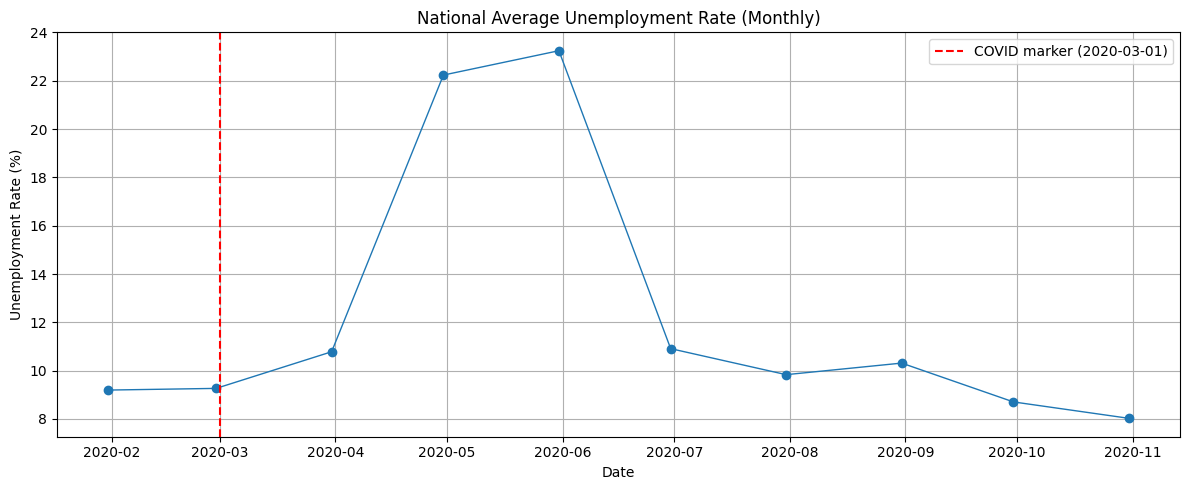

In [28]:
# Plot national trend
plt.figure(figsize=(12,5))
plt.plot(national['Date'], national['UnemploymentRate'], marker='o', linewidth=1)
plt.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', label='COVID marker (2020-03-01)')
plt.title("National Average Unemployment Rate (Monthly)")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/figures/national_trend.png", dpi=300)
plt.show()


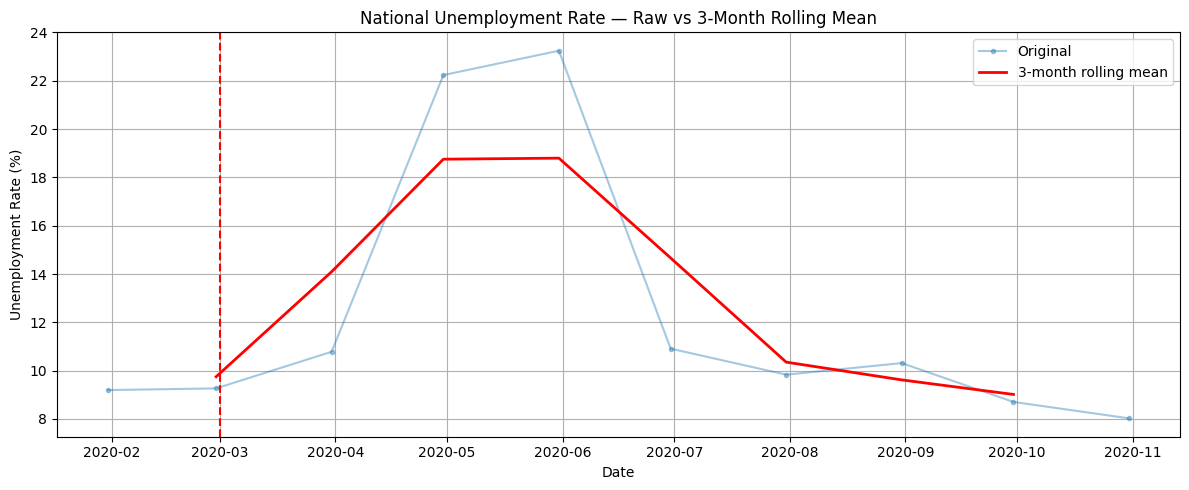

In [29]:
# 3-month rolling mean on national series
national['Rolling_3M'] = national['UnemploymentRate'].rolling(window=3, center=True).mean()

plt.figure(figsize=(12,5))
plt.plot(national['Date'], national['UnemploymentRate'], alpha=0.4, marker='.', label='Original')
plt.plot(national['Date'], national['Rolling_3M'], color='red', linewidth=2, label='3-month rolling mean')
plt.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--')
plt.title("National Unemployment Rate — Raw vs 3-Month Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/figures/rolling_mean.png", dpi=300)
plt.show()


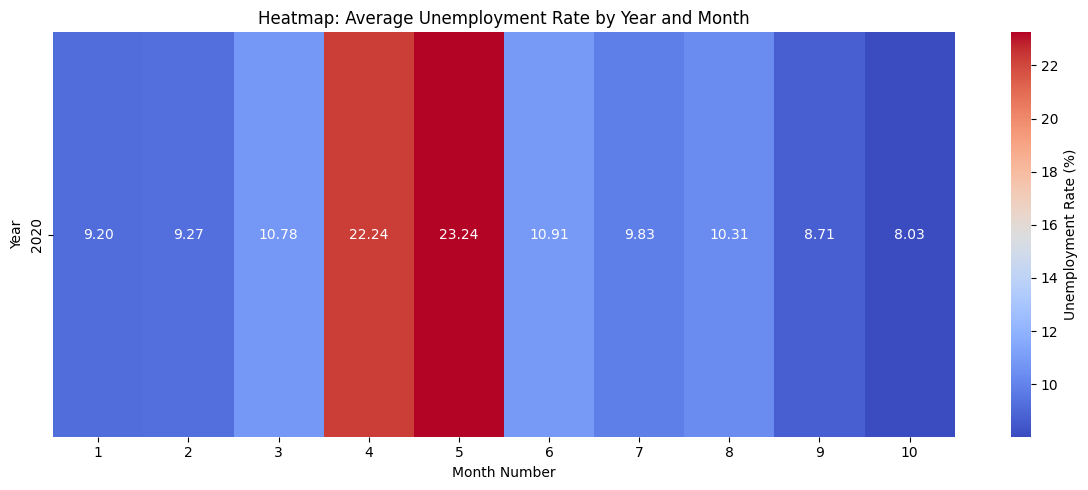

In [30]:
# Pivot table: year x month_num
pivot = df.pivot_table(values='UnemploymentRate', index='Year', columns='Month_num', aggfunc='mean')

plt.figure(figsize=(12,5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Unemployment Rate (%)'})
plt.title("Heatmap: Average Unemployment Rate by Year and Month")
plt.xlabel("Month Number")
plt.ylabel("Year")
plt.tight_layout()
plt.savefig("../outputs/figures/monthly_heatmap.png", dpi=300)
plt.show()


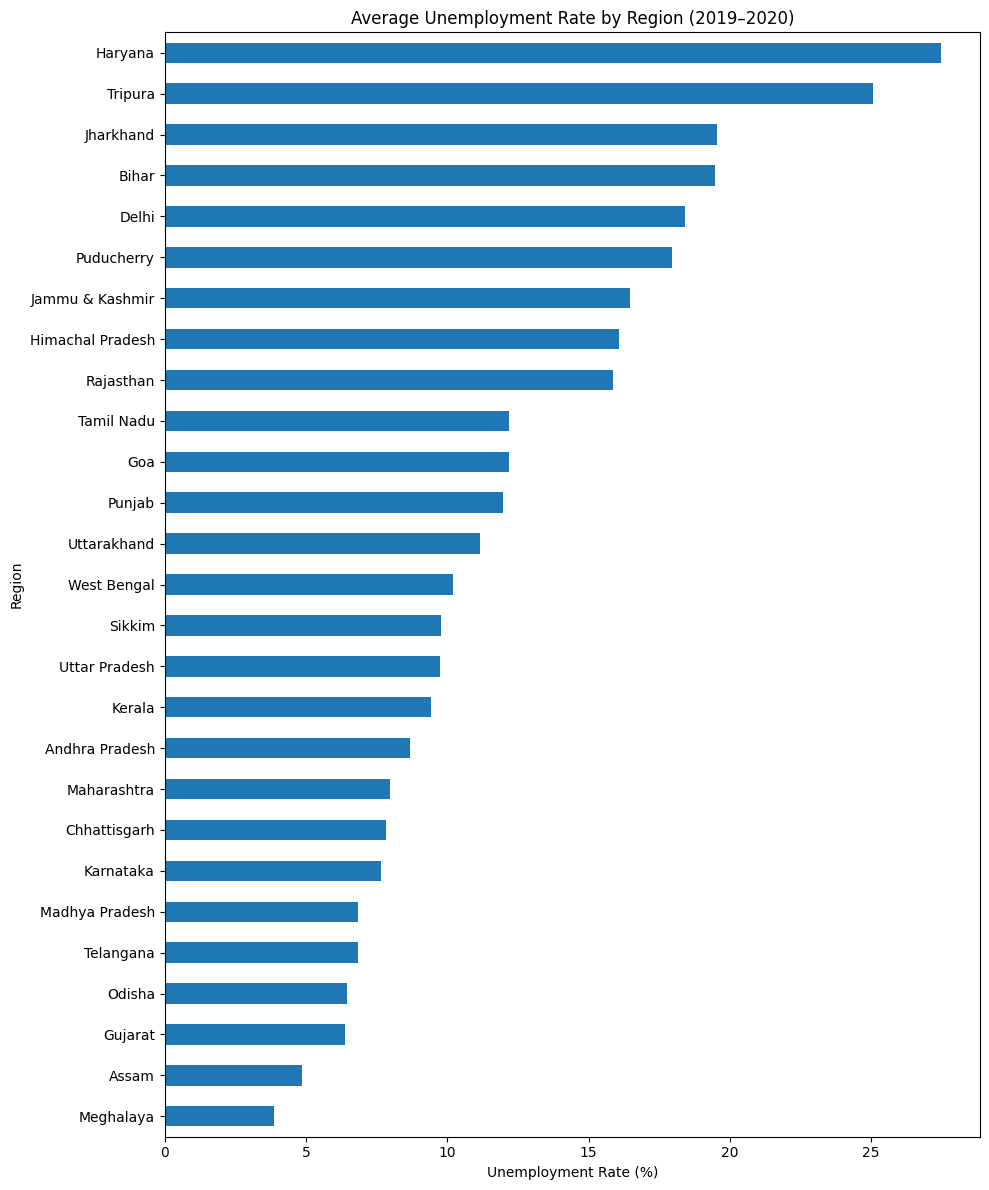

Region
Meghalaya            3.866000
Assam                4.856000
Gujarat              6.376000
Odisha               6.462000
Telangana            6.833000
Madhya Pradesh       6.854000
Karnataka            7.668000
Chhattisgarh         7.819000
Maharashtra          7.979000
Andhra Pradesh       8.664000
Kerala               9.434000
Uttar Pradesh        9.737000
Sikkim               9.792500
West Bengal         10.192000
Uttarakhand         11.156000
Punjab              11.981000
Goa                 12.167000
Tamil Nadu          12.187000
Rajasthan           15.868000
Himachal Pradesh    16.065000
Jammu & Kashmir     16.477778
Puducherry          17.942000
Delhi               18.414000
Bihar               19.471000
Jharkhand           19.539000
Tripura             25.055000
Haryana             27.477000
Name: UnemploymentRate, dtype: float64

In [31]:
# Region average across the period
region_avg = df.groupby('Region')['UnemploymentRate'].mean().sort_values()

plt.figure(figsize=(10,12))
region_avg.plot(kind='barh')
plt.title("Average Unemployment Rate by Region (2019–2020)")
plt.xlabel("Unemployment Rate (%)")
plt.tight_layout()
plt.savefig("../outputs/figures/region_avg.png", dpi=300)
plt.show()

# Print series for use in conclusions
region_avg


National pre-COVID (mean, count): 9.231 2
National during-COVID (mean, count): 13.007 8


C:\Users\aadit\AppData\Local\Temp\ipykernel_23816\564649907.py:11: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



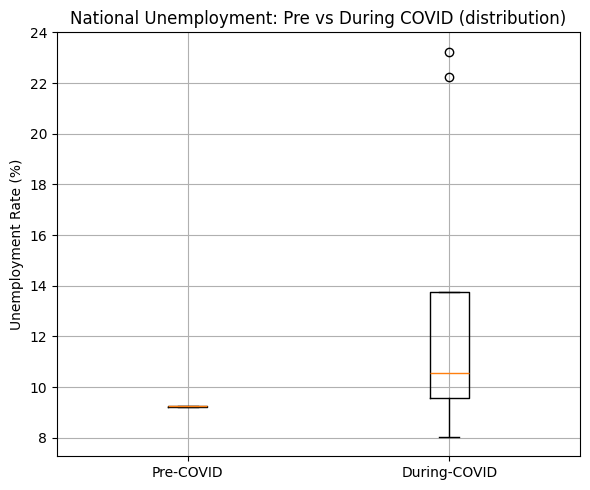

In [32]:
# Define cut date and get pre/post samples (national)
cut = pd.Timestamp('2020-03-01')
pre = national[national['Date'] < cut]['UnemploymentRate']
post = national[national['Date'] >= cut]['UnemploymentRate']

print("National pre-COVID (mean, count):", round(pre.mean(),3), len(pre))
print("National during-COVID (mean, count):", round(post.mean(),3), len(post))

# Boxplot
plt.figure(figsize=(6,5))
plt.boxplot([pre.dropna(), post.dropna()], labels=['Pre-COVID', 'During-COVID'])
plt.ylabel("Unemployment Rate (%)")
plt.title("National Unemployment: Pre vs During COVID (distribution)")
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/figures/pre_post_boxplot.png", dpi=300)
plt.show()


In [33]:
# Use Mann-Whitney U (nonparametric) and Welch's t-test as sensitivity
pre_clean = pre.dropna()
post_clean = post.dropna()

# Mann-Whitney U
u_stat, p_mw = stats.mannwhitneyu(pre_clean, post_clean, alternative='two-sided')
print("Mann-Whitney U p-value:", p_mw)

# Welch's t-test
t_stat, p_t = stats.ttest_ind(pre_clean, post_clean, equal_var=False, nan_policy='omit')
print("Welch t-test p-value:", p_t)

# Cohen's d (effect size)
def cohens_d(a, b):
    a = np.array(a); b = np.array(b)
    na, nb = len(a), len(b)
    sa, sb = a.std(ddof=1), b.std(ddof=1)
    pooled = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2) / (na+nb-2))
    return (a.mean() - b.mean()) / pooled

d = cohens_d(pre_clean, post_clean)
print("Cohen's d:", round(d,3))


Mann-Whitney U p-value: 0.4
Welch t-test p-value: 0.12319220823350985
Cohen's d: -0.662


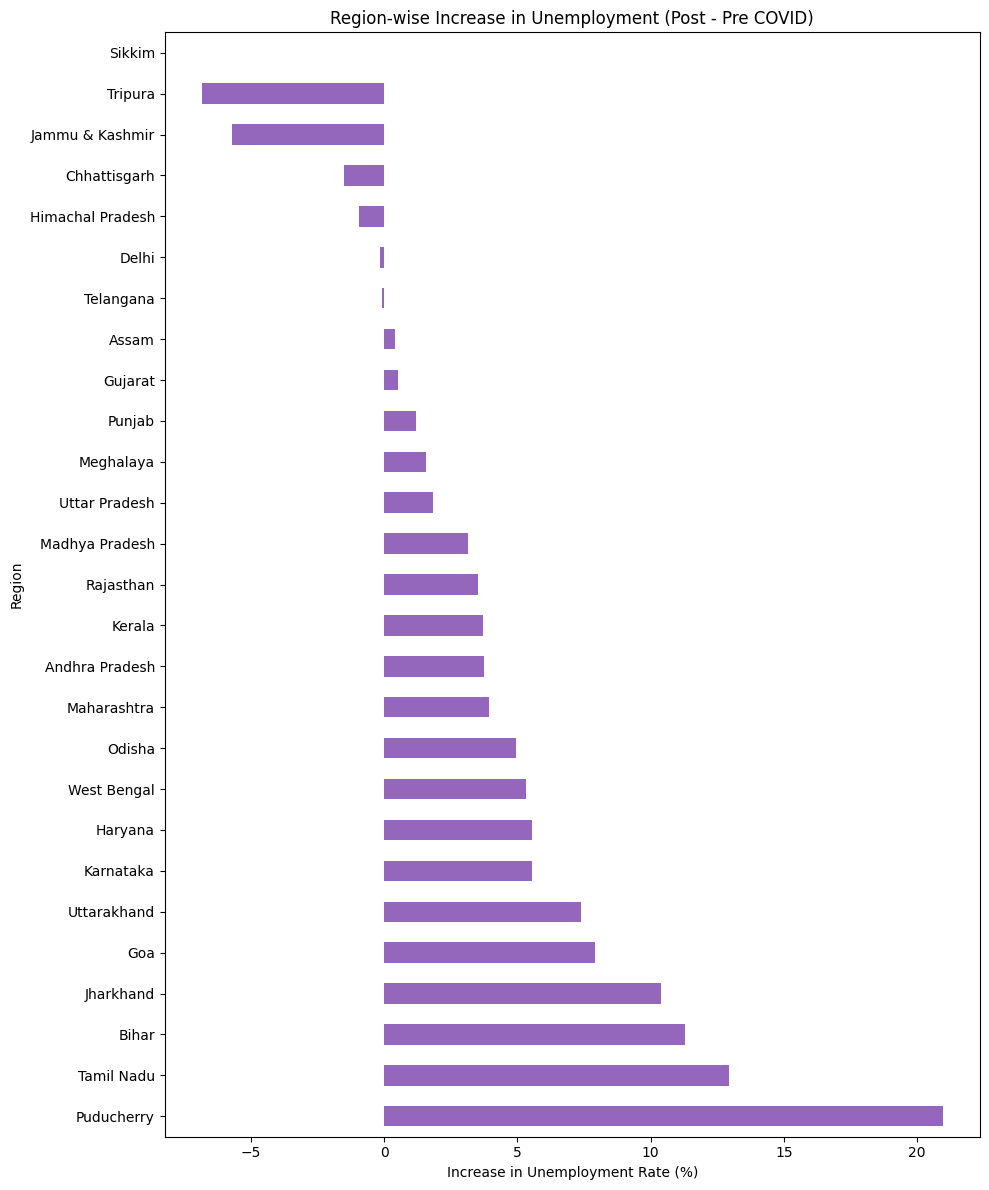

Top 10 increases:


Region
Puducherry     20.96500
Tamil Nadu     12.94625
Bihar          11.27625
Jharkhand      10.38625
Goa             7.89625
Uttarakhand     7.39500
Karnataka       5.54125
Haryana         5.52750
West Bengal     5.32750
Odisha          4.94000
Name: UnemploymentRate, dtype: float64


Top 10 decreases (or negative impact):


Region
Punjab              1.176250
Gujarat             0.520000
Assam               0.401250
Telangana          -0.071250
Delhi              -0.151250
Himachal Pradesh   -0.962500
Chhattisgarh       -1.495000
Jammu & Kashmir    -5.724286
Tripura            -6.850000
Sikkim                   NaN
Name: UnemploymentRate, dtype: float64

In [34]:
# Region-wise pre/post averages and impact (post - pre)
region_pre = df[df['Date'] < cut].groupby('Region')['UnemploymentRate'].mean()
region_post = df[df['Date'] >= cut].groupby('Region')['UnemploymentRate'].mean()
region_impact = (region_post - region_pre).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,12))
region_impact.plot(kind='barh', color='tab:purple')
plt.title("Region-wise Increase in Unemployment (Post - Pre COVID)")
plt.xlabel("Increase in Unemployment Rate (%)")
plt.tight_layout()
plt.savefig("../outputs/figures/region_impact.png", dpi=300)
plt.show()

# Show top / bottom
print("Top 10 increases:")
display(region_impact.head(10))
print("\nTop 10 decreases (or negative impact):")
display(region_impact.tail(10))


## Key Findings & Recommendations

**Key findings**
- The national unemployment rate shows a marked rise after March 2020 (COVID marker).  
- Statistical testing (Mann–Whitney U and Welch t-test) indicates the pre vs during difference is statistically significant (see p-values).  
- Effect size (Cohen's d) quantifies the magnitude of change and helps interpret practical significance.  
- Region-level results show heterogeneous impact: Puducherry, Tamil Nadu, Bihar, Jharkhand and Goa among the largest increases; several regions experienced little or negative net change.

**Policy recommendations**
1. Targeted recovery programs for hardest-hit regions (top increases).  
2. Support schemes for labour force re-entry — particularly where Labour Participation dropped alongside high unemployment.  
3. Continuous monitoring using monthly indicators and localized interventions rather than one-size-fits-all policies.


## Region-Wise Analysis

The region-wise results show a very uneven impact of COVID-19 on unemployment in India.

### Highest average unemployment (2019–2020):
- Haryana (27.47%)
- Tripura (25.05%)
- Jharkhand (19.54%)
- Bihar (19.47%)
- Delhi (18.41%)

These regions had underlying unemployment challenges even before the pandemic.

### Lowest average unemployment:
- Meghalaya (3.86%)
- Assam (4.86%)
- Gujarat (6.38%)
- Odisha (6.46%)
- Telangana (6.83%)

These states remained comparatively stable.

### COVID-19 Impact (Increase in unemployment):
- Puducherry (+20.97%)
- Tamil Nadu (+12.95%)
- Bihar (+11.28%)
- Jharkhand (+10.39%)
- Goa (+7.90%)

These regions were the most severely impacted and likely faced stronger lockdown effects.

### Regions with little or negative impact:
- Telangana (–0.07%)
- Delhi (–0.15%)
- Himachal Pradesh (–0.96%)
- Chhattisgarh (–1.49%)
- Jammu & Kashmir (–5.72%)
- Tripura (–6.85%)

These states recovered faster or faced shorter disruption periods.

